In [ ]:
import vsms
import importlib
importlib.reload(vsms)
import vsms.exsample_benchmark
import vsms.exsample_sampler
importlib.reload(vsms.exsample_sampler)
importlib.reload(vsms.exsample_benchmark)
import matplotlib
import matplotlib.pyplot as plt
from vsms.exsample_benchmark import *
from vsms.exsample_sampler import *
importlib.reload(vsms.exsample_sampler)
importlib.reload(vsms.exsample_benchmark)
from vsms.exsample_sampler import *
from vsms.exsample_benchmark import *

In [2]:
root = '/home/gridsan/omoll/data/exsample_data/'
#root = '/big_fast_drive/orm/exsample_data/'

dsm = [  DatasetMetadata(name='dashcam_unified_ng',
                    boxpath=f'{root}/dashcam_unified_ng.track_ids.clean.parquet',
                    track_id='tid',
                    frame_id='frame_idx',
                    video_len=1164226,
                    category='category',
                    categories=[
                        'person',
                        'bicycle',
                        'bus',
                        'truck',
                        'traffic light',
                        'fire hydrant',
                        'stop sign'],
                    default_chunks=(f'{root}/dash_metadata_by_frame.parquet', 'chunk_id'),
                         # this chunk id already is split by file and then 30 minutes
                    logitpath=f'{root}/dashcam_logits_secon_version.parquet',
                    logitsplit='subset'),
    DatasetMetadata(name='bdd1k',
                    boxpath=f'{root}/bdd1k.track_ids.clean.parquet',
                    track_id='tid',
                    frame_id='frame_idx',
                    video_len=389662,  # 1/3 frames of 1k ~40 second clips.
                    category='category',
                    categories=['person',
                                'rider',
                                'bus',
                                'truck',
                                'bike',
                                'motor',
                                'traffic light',
                                'traffic sign',],
                    default_chunks=(f'{root}/bdd_metadata_by_frame.parquet', 'clip_id'),
                    logitpath=f'{root}/bdd_logits_v0.parquet',
                    logitsplit='subset'),
        DatasetMetadata(name='bdd_mot_labels',
                boxpath=f'{root}/bdd_mot_labels.parquet',
                track_id='id',
                frame_id='frame_idx',
                video_len=None,
                category='category',
                categories=['car','pedestrian','truck','bicycle','rider','bus','motorcycle'],
                default_chunks=(f'{root}/bdd_mot_frames.parquet','video_name'),
                logitpath=None,
                logitsplit=None),
    DatasetMetadata(name='jackson-town-square',
                        boxpath=f'{root}/jackson-town-square_boxes_tids_filtered.parquet',
                        track_id='tid', frame_id='frame_idx', category='category',
                        categories=['car', 'person', 'truck', 'bus', 'dog', 'motorcycle'],
                        video_len=None, default_chunks=None, 
                        logitpath=None, logitsplit=None),
   DatasetMetadata(name='archie-day',
                    boxpath=f'{root}/archie-day_boxes_tids_filtered.parquet',
                    track_id='tid', frame_id='frame_idx', category='category',
                    categories=['car', 'bicycle', 'person', 'motorcycle', 'truck', 'bus'], 
                    video_len=None, default_chunks=None, 
                    logitpath=None, logitsplit=None),
   DatasetMetadata(name='amsterdam',
                    boxpath=f'{root}/amsterdam_boxes_tids_filtered.parquet',
                    track_id='tid', frame_id='frame_idx', category='category',
                    categories=['boat', 'car', 'person', 'bicycle', 'truck', 'motorcycle', 'dog'],                        video_len=None, default_chunks=None, 
                    logitpath=None, logitsplit=None)
]

In [3]:
bms = []
for m in dsm:
    bms.append(BenchmarkDataset(m))

In [6]:
# hdfs = []
# for bm in bms:
#     df = get_histogram(bm, bm.default_chunks)
#     hdfs.append(df)
# hc = pd.concat(hdfs, ignore_index=True)

In [8]:
# order_col = 'N'
# def assign_order(gp, order_col):
#     gp = gp.sort_values(order_col, ascending=False)
#     gp = gp.assign(**{f'order{order_col}':np.arange(gp.shape[0])})
#     return gp

/nvme_drive/vsms3/lib/python3.7/site-packages/plotnine/facets/facet.py:558: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


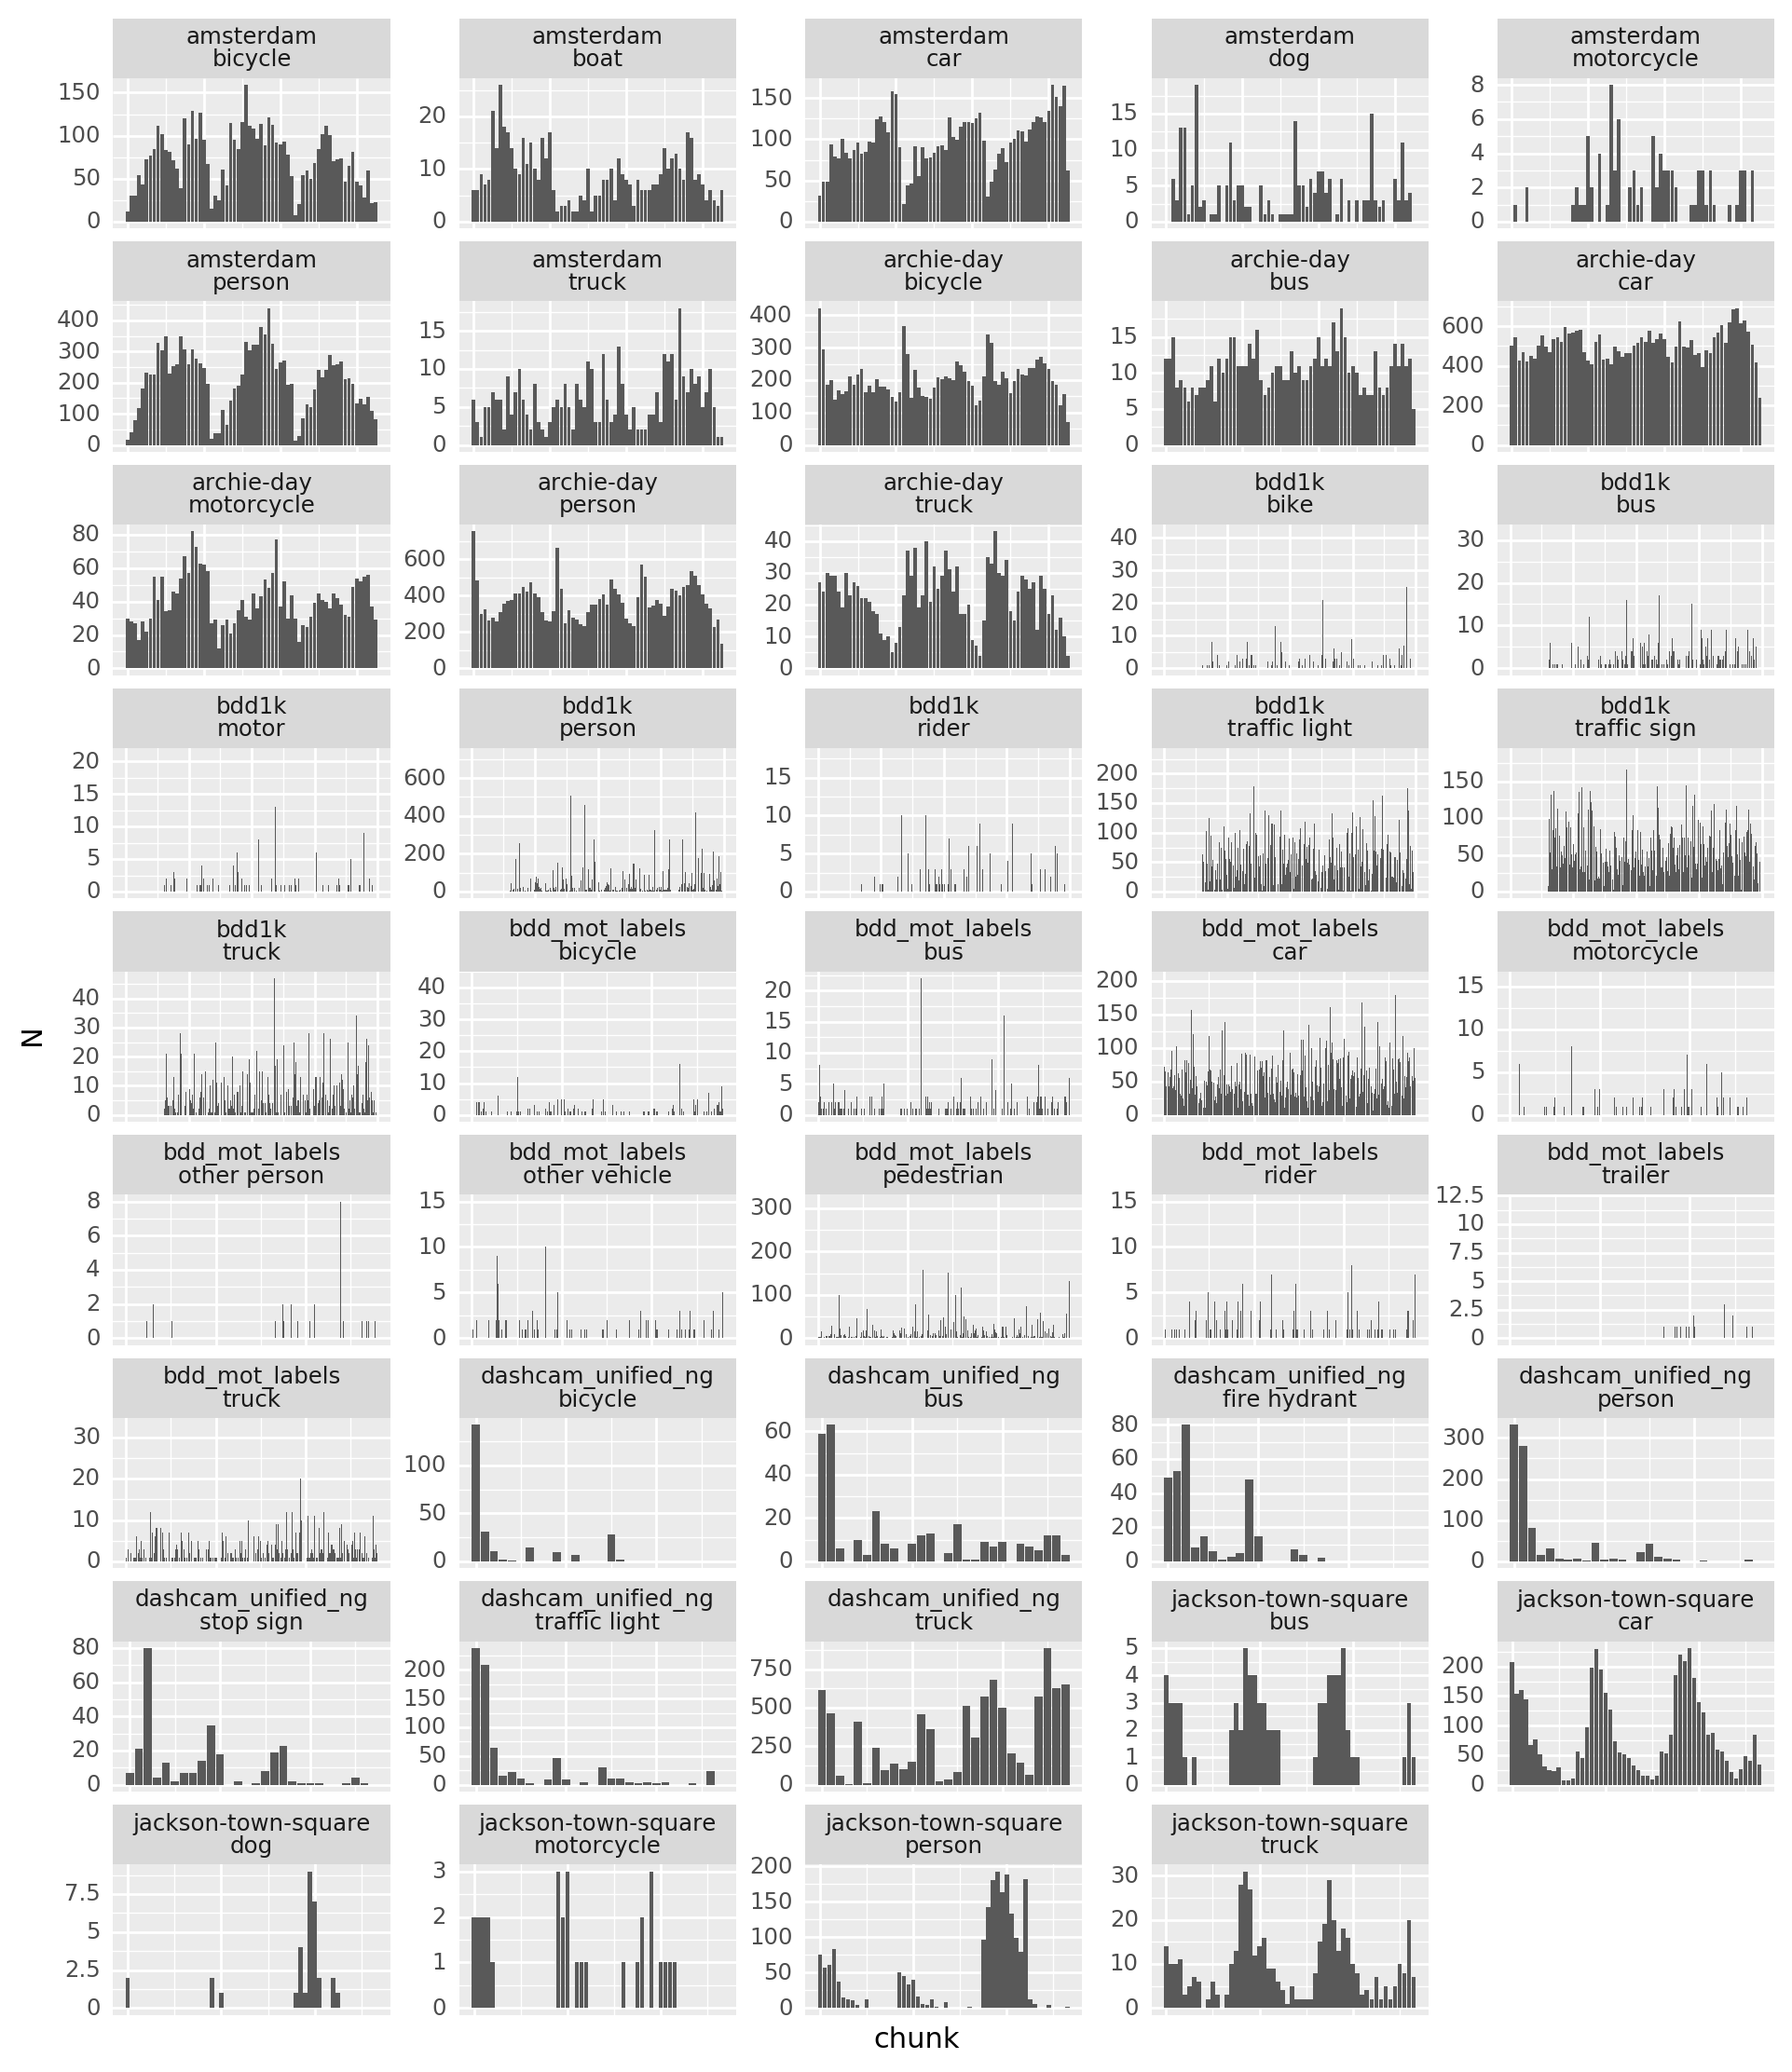

<ggplot: (8745168539726)>

In [131]:
(ggplot(hc) # archie day
  + geom_col(aes(x='chunk', y='N'))
  + facet_wrap(facets=['dataset','category'], scales='free', ncol=5)
  + theme(figure_size=(5*2.3,9*1.5), axis_text_x=element_blank(), axis_ticks=element_blank(), 
         subplots_adjust={'wspace': 0.25})
)

In [ ]:
hc2 = hc.groupby(['dataset', 'category'], as_index=False).apply(lambda gp : assign_order(gp, 'N'))

/nvme_drive/vsms3/lib/python3.7/site-packages/plotnine/facets/facet.py:558: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


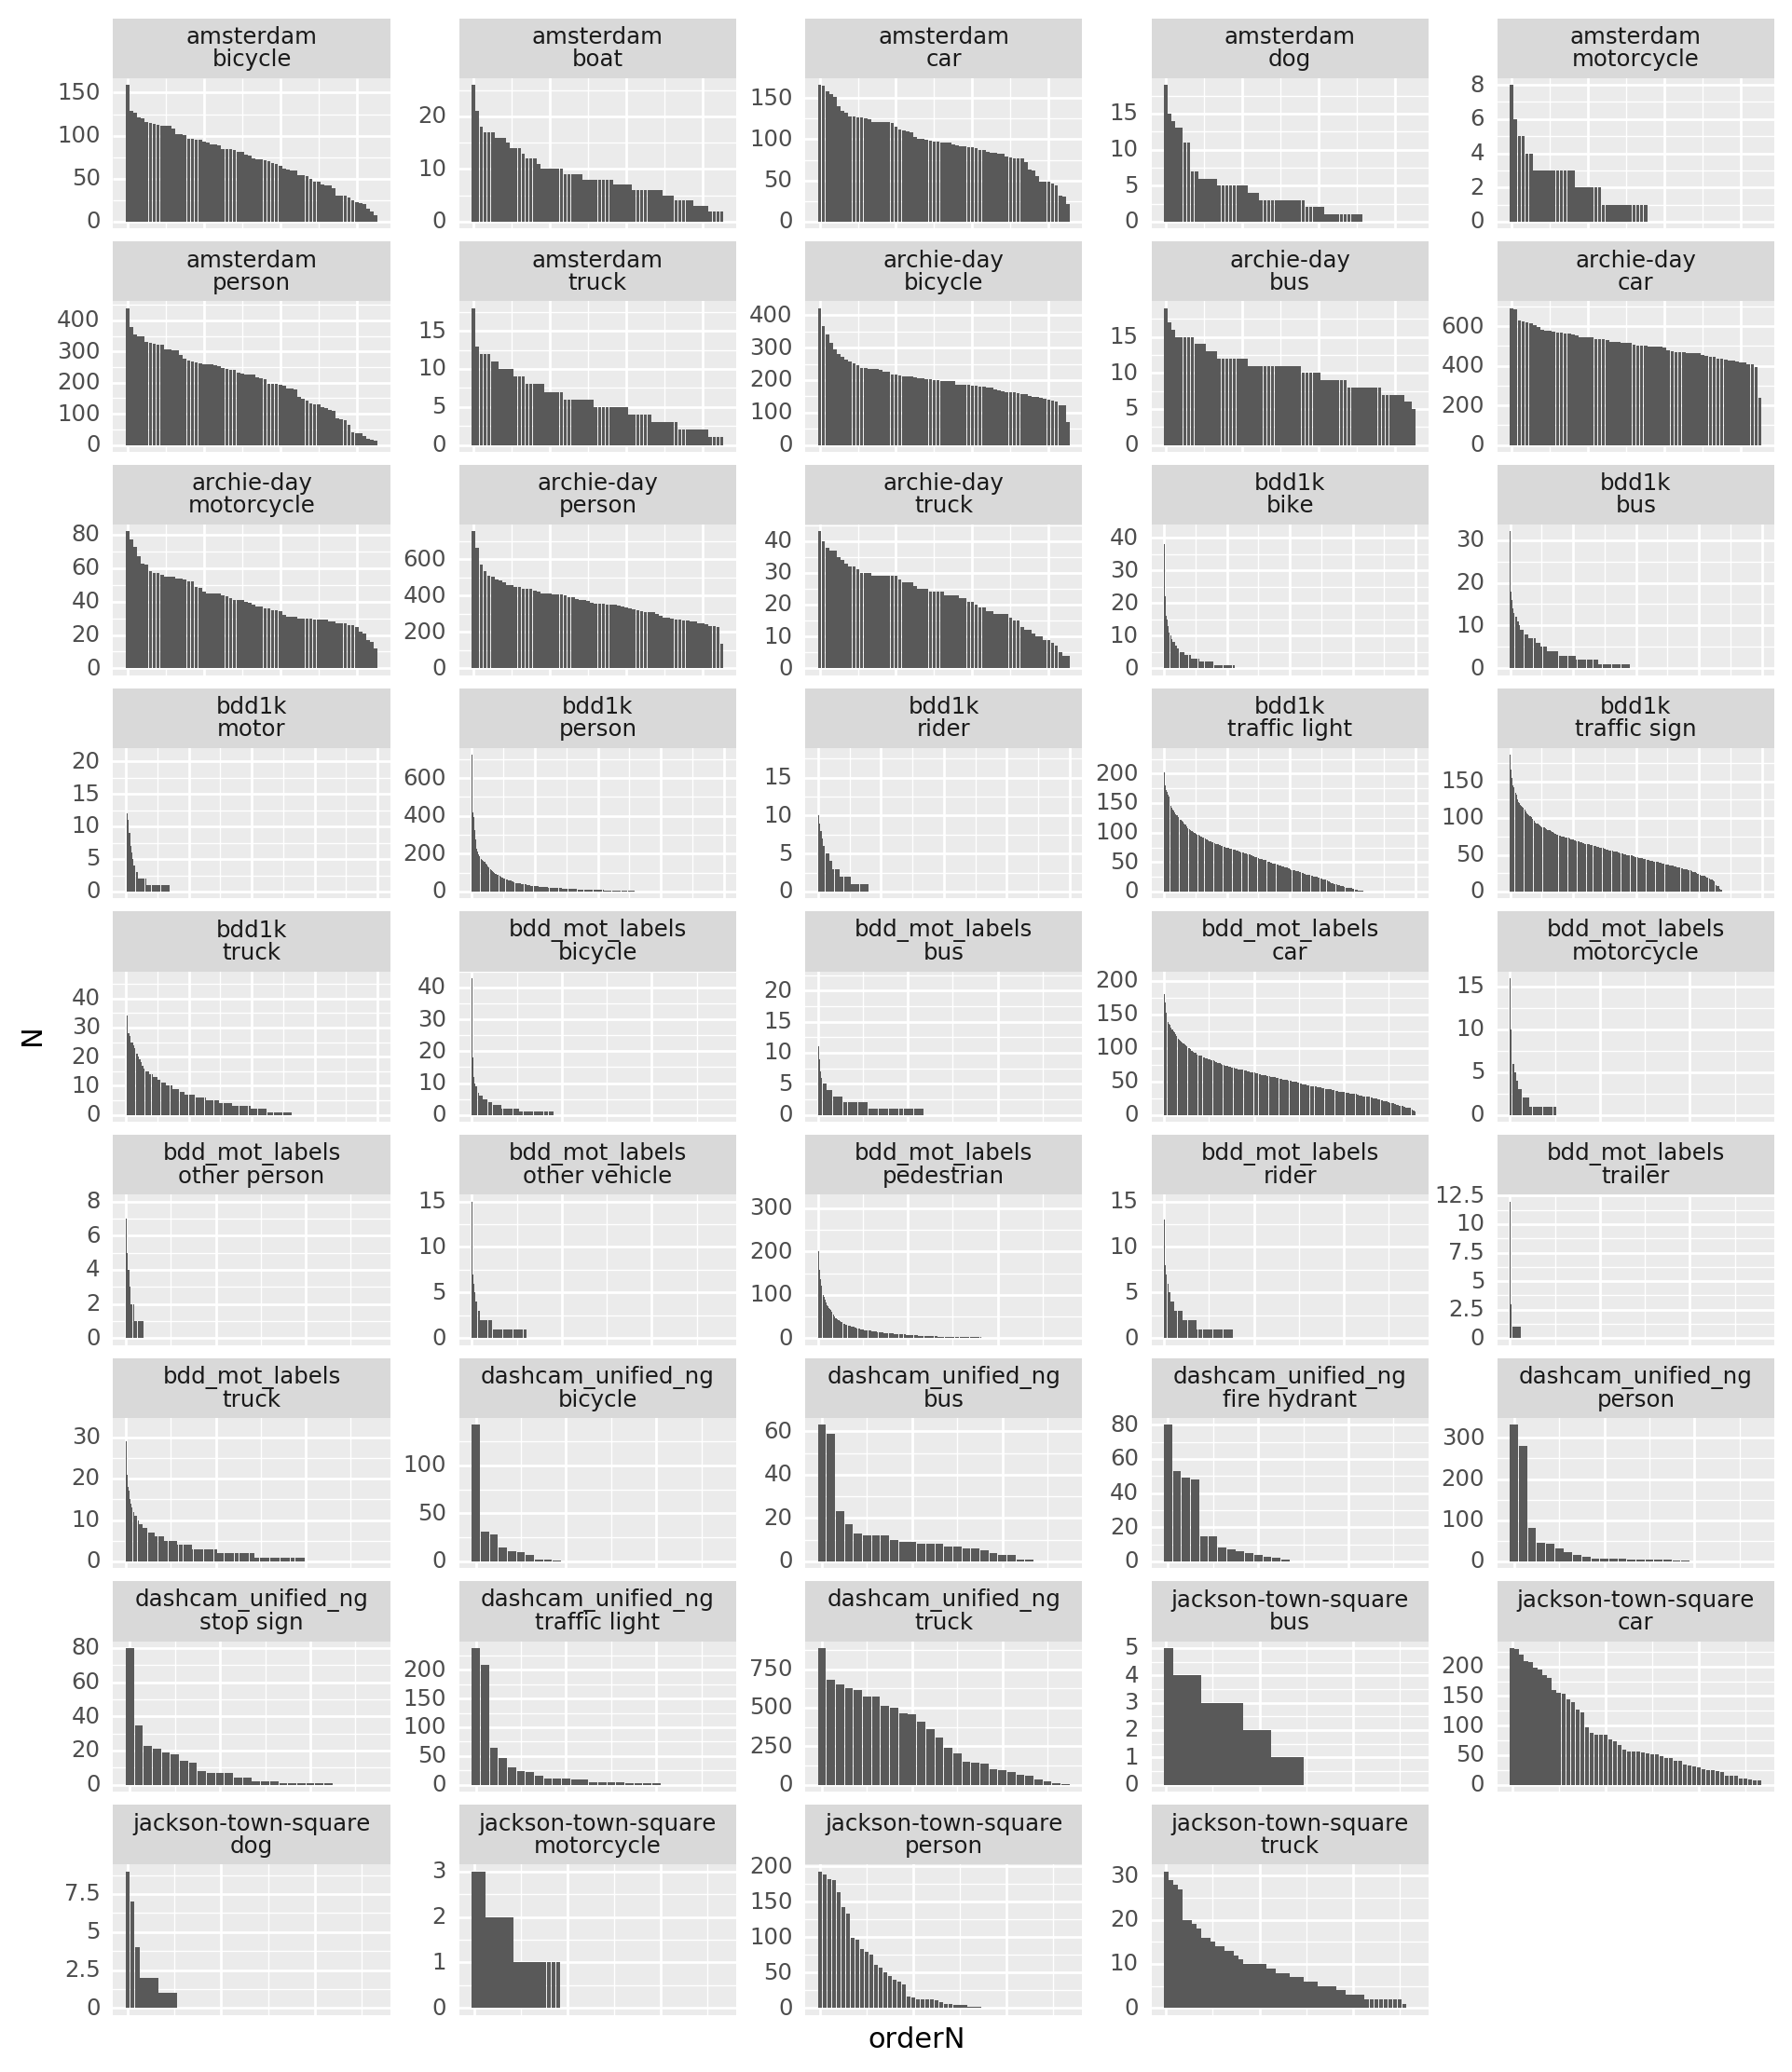

<ggplot: (-9223363291705524294)>

In [127]:
(ggplot(hc2) # archie day
  + geom_col(aes(x='orderN', y='N'))
  + facet_wrap(facets=['dataset','category'], scales='free', ncol=5)
  + theme(figure_size=(5*2.3,9*1.5), axis_text_x=element_blank(), axis_ticks=element_blank(), 
         subplots_adjust={'wspace': 0.25})
)

In [4]:
def generate_configs(num_reps=11):
    batch_size=10
    combos = []
    for ds in bms:
        for _ in range(num_reps):
            baselines = named_prod(
                order=['random', 'random+'],
                split=['nosplit'],
                batch_size=[batch_size],
                object_class=ds.categories,
                dataset=[ds],
                score_method=[None]
            )
            exsample = named_prod(
                order=['random+'],
                split=['default'],
                batch_size=[batch_size],
                object_class=ds.categories,
                dataset=[ds],
                score_method=[(StatScorer, dict(stat='gt', exp_model='ts')),]
            ),
            exsample = named_prod(
                order=['random+'],
                split=['default'],
                batch_size=[batch_size],
                object_class=ds.categories,
                dataset=[ds],
                score_method=[(StatScorer, dict(stat='gt', exp_model='ucb')),]
            )

            combos.append(baselines)
            combos.append(exsample)

    configs = []
    for c in combos:
        for tup in c:
            configs.append(tup)
    return configs

In [5]:
import ray

In [6]:
ray.init()
from ray.util.multiprocessing import Pool
pool = Pool(40)

2020-09-12 22:42:17,671	INFO resource_spec.py:231 -- Starting Ray with 241.94 GiB memory available for workers and up to 107.69 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-09-12 22:42:18,704	INFO services.py:1193 -- View the Ray dashboard at localhost:8265


In [7]:
import scipy
import scipy.stats

In [8]:
cfgs = generate_configs(11)

def run_config(config, threshold=.9):            
    exp = make_experiment(config)
    exp.run_up_to(threshold=threshold, disable_tqdm=True)
    df = exp.get_results()
    return df

In [9]:
results = pool.map(run_config, cfgs)

(pid=raylet) E0912 22:44:51.410550 47597 47606 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff0100008074000000, data_size=4375863996, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
(pid=48552) 2020-09-12 22:44:51,558	INFO (unknown file):0 -- gc.collect() freed 15 refs in 0.05070488108322024 seconds
(pid=48445) 2020-09-12 22:44:51,556	INFO (unknown file):0 -- gc.collect() freed 15 refs in 0.038827158976346254 seconds
(pid=48584) 2020-09-12 22:44:51,542	INFO (unknown file):0 -- gc.collect() freed 15 refs in 0.036317081190645695 seconds
(pid=48469) 2020-09-12 22:44:51,557	INFO (unknown file):0 -- gc.collect() freed 15 refs in 0.05043672816827893 seconds
(pid=48543) 2020-09-12 22:44:51,543	INFO (unknown file):0 -- gc.collect() freed 15 refs in 0.03723876201547682 seconds
(pid=48553) 2020-09-12 22:44:51,545	INFO (unknown file):0 -- gc.collect() freed 15 refs in 0.038927454967051744 seconds
(pid=48494) 2020-09-12 22:44:51,562	INFO (unknown file):

(pid=47653) 2020-09-12 22:44:52,046	INFO (unknown file):0 -- gc.collect() freed 2416 refs in 0.11905743600800633 seconds
(pid=raylet) E0912 22:44:52.410996 47597 47606 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff0100008074000000, data_size=4375863996, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
(pid=47648) 2020-09-12 22:44:52,567	INFO (unknown file):0 -- gc.collect() freed 582 refs in 0.08924854686483741 seconds
(pid=47732) 2020-09-12 22:44:52,586	INFO (unknown file):0 -- gc.collect() freed 411 refs in 0.10717179207131267 seconds
(pid=47644) 2020-09-12 22:44:52,586	INFO (unknown file):0 -- gc.collect() freed 611 refs in 0.10399733087979257 seconds
(pid=47654) 2020-09-12 22:44:52,592	INFO (unknown file):0 -- gc.collect() freed 203 refs in 0.10327514191158116 seconds
(pid=47636) 2020-09-12 22:44:52,596	INFO (unknown file):0 -- gc.collect() freed 984 refs in 0.11799618694931269 seconds
(pid=47661) 2020-09-12 22:44:52,594	INFO (unknown fi

(pid=47741) 2020-09-12 22:45:03,211	INFO (unknown file):0 -- gc.collect() freed 690 refs in 0.14981787302531302 seconds
(pid=47638) 2020-09-12 22:45:03,208	INFO (unknown file):0 -- gc.collect() freed 462 refs in 0.1445422349497676 seconds
(pid=47657) 2020-09-12 22:45:03,219	INFO (unknown file):0 -- gc.collect() freed 893 refs in 0.09976067300885916 seconds
(pid=47652) 2020-09-12 22:45:03,324	INFO (unknown file):0 -- gc.collect() freed 23 refs in 0.1306600000243634 seconds
(pid=47733) 2020-09-12 22:45:03,424	INFO (unknown file):0 -- gc.collect() freed 89 refs in 0.14932795497588813 seconds
(pid=47651) 2020-09-12 22:45:03,451	INFO (unknown file):0 -- gc.collect() freed 412 refs in 0.08210984198376536 seconds
(pid=raylet) E0912 22:45:03.974891 47597 47606 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff0100008075000000, data_size=4375865404, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
(pid=47644) 2020-09-12 22:45:04,174	INFO (unknown file):0

(pid=47641) 2020-09-12 22:45:10,225	INFO (unknown file):0 -- gc.collect() freed 931 refs in 0.14623714098706841 seconds
(pid=47632) 2020-09-12 22:45:10,258	INFO (unknown file):0 -- gc.collect() freed 698 refs in 0.18452821299433708 seconds
(pid=47733) 2020-09-12 22:45:10,244	INFO (unknown file):0 -- gc.collect() freed 48 refs in 0.1594142890535295 seconds
(pid=47644) 2020-09-12 22:45:10,333	INFO (unknown file):0 -- gc.collect() freed 328 refs in 0.08518238412216306 seconds
(pid=47651) 2020-09-12 22:45:10,464	INFO (unknown file):0 -- gc.collect() freed 632 refs in 0.06644395994953811 seconds
(pid=raylet) E0912 22:45:17.975996 47597 47606 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff0100008075000000, data_size=4375865404, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
(pid=47654) 2020-09-12 22:45:18,143	INFO (unknown file):0 -- gc.collect() freed 350 refs in 0.0836219759657979 seconds
(pid=47660) 2020-09-12 22:45:18,147	INFO (unknown file):

(pid=47731) 2020-09-12 22:45:38,775	INFO (unknown file):0 -- gc.collect() freed 46 refs in 0.11580837494693696 seconds
(pid=raylet) E0912 22:45:39.310124 47597 47606 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff0100008076000000, data_size=4375863996, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
(pid=47657) 2020-09-12 22:45:39,441	INFO (unknown file):0 -- gc.collect() freed 909 refs in 0.09153154492378235 seconds
(pid=47634) 2020-09-12 22:45:39,441	INFO (unknown file):0 -- gc.collect() freed 345 refs in 0.09119988209567964 seconds
(pid=47651) 2020-09-12 22:45:39,454	INFO (unknown file):0 -- gc.collect() freed 325 refs in 0.08569497894495726 seconds
(pid=47730) 2020-09-12 22:45:39,446	INFO (unknown file):0 -- gc.collect() freed 904 refs in 0.09629416698589921 seconds
(pid=47732) 2020-09-12 22:45:39,449	INFO (unknown file):0 -- gc.collect() freed 416 refs in 0.09845037199556828 seconds
(pid=47736) 2020-09-12 22:45:39,452	INFO (unknown file

(pid=raylet) E0912 22:45:53.001619 47597 47606 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff0100008078000000, data_size=4375863996, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
(pid=47654) 2020-09-12 22:45:53,195	INFO (unknown file):0 -- gc.collect() freed 770 refs in 0.08567432989366353 seconds
(pid=47660) 2020-09-12 22:45:53,210	INFO (unknown file):0 -- gc.collect() freed 496 refs in 0.11620289413258433 seconds
(pid=47651) 2020-09-12 22:45:53,205	INFO (unknown file):0 -- gc.collect() freed 661 refs in 0.11553379497490823 seconds
(pid=47731) 2020-09-12 22:45:53,189	INFO (unknown file):0 -- gc.collect() freed 60 refs in 0.10888660605996847 seconds
(pid=47730) 2020-09-12 22:45:53,194	INFO (unknown file):0 -- gc.collect() freed 1055 refs in 0.11574888997711241 seconds
(pid=47732) 2020-09-12 22:45:53,164	INFO (unknown file):0 -- gc.collect() freed 1155 refs in 0.08364527393132448 seconds
(pid=47736) 2020-09-12 22:45:53,225	INFO (unknown fi

(pid=47632) 2020-09-12 22:45:56,191	INFO (unknown file):0 -- gc.collect() freed 959 refs in 0.11914989002980292 seconds
(pid=47653) 2020-09-12 22:45:56,201	INFO (unknown file):0 -- gc.collect() freed 23 refs in 0.14229394518770278 seconds
(pid=raylet) E0912 22:46:04.045955 47597 47606 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff0100008079000000, data_size=4375865404, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
(pid=47644) 2020-09-12 22:46:04,214	INFO (unknown file):0 -- gc.collect() freed 528 refs in 0.09060800494626164 seconds
(pid=47649) 2020-09-12 22:46:04,206	INFO (unknown file):0 -- gc.collect() freed 809 refs in 0.08963626297190785 seconds
(pid=47654) 2020-09-12 22:46:04,206	INFO (unknown file):0 -- gc.collect() freed 839 refs in 0.09042200888507068 seconds
(pid=47730) 2020-09-12 22:46:04,213	INFO (unknown file):0 -- gc.collect() freed 583 refs in 0.0964020958635956 seconds
(pid=47733) 2020-09-12 22:46:04,212	INFO (unknown file)

(pid=raylet) E0912 22:46:11.047093 47597 47606 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff0100008079000000, data_size=4375865404, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
(pid=47657) 2020-09-12 22:46:11,185	INFO (unknown file):0 -- gc.collect() freed 805 refs in 0.10502482601441443 seconds
(pid=47659) 2020-09-12 22:46:11,187	INFO (unknown file):0 -- gc.collect() freed 482 refs in 0.09863411099649966 seconds
(pid=47730) 2020-09-12 22:46:11,181	INFO (unknown file):0 -- gc.collect() freed 358 refs in 0.07708493410609663 seconds
(pid=47732) 2020-09-12 22:46:11,183	INFO (unknown file):0 -- gc.collect() freed 280 refs in 0.10194447985850275 seconds
(pid=47733) 2020-09-12 22:46:11,178	INFO (unknown file):0 -- gc.collect() freed 640 refs in 0.07351972791366279 seconds
(pid=47729) 2020-09-12 22:46:11,168	INFO (unknown file):0 -- gc.collect() freed 972 refs in 0.0875348539557308 seconds
(pid=47638) 2020-09-12 22:46:11,192	INFO (unknown file

(pid=raylet) E0912 22:46:26.356739 47597 47606 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff010000807a000000, data_size=4375863996, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
(pid=47651) 2020-09-12 22:46:26,500	INFO (unknown file):0 -- gc.collect() freed 785 refs in 0.08101393701508641 seconds
(pid=47730) 2020-09-12 22:46:26,479	INFO (unknown file):0 -- gc.collect() freed 636 refs in 0.08411300089210272 seconds
(pid=47736) 2020-09-12 22:46:26,515	INFO (unknown file):0 -- gc.collect() freed 768 refs in 0.14140991889871657 seconds
(pid=47733) 2020-09-12 22:46:26,482	INFO (unknown file):0 -- gc.collect() freed 253 refs in 0.08507908694446087 seconds
(pid=47729) 2020-09-12 22:46:26,506	INFO (unknown file):0 -- gc.collect() freed 420 refs in 0.10323457093909383 seconds
(pid=47741) 2020-09-12 22:46:26,499	INFO (unknown file):0 -- gc.collect() freed 228 refs in 0.09012247994542122 seconds
(pid=47638) 2020-09-12 22:46:26,501	INFO (unknown fil

(pid=raylet) E0912 22:47:19.595355 47597 47606 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff0100008080000000, data_size=4220592158, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
(pid=47649) 2020-09-12 22:47:19,750	INFO (unknown file):0 -- gc.collect() freed 622 refs in 0.09063194203190506 seconds
(pid=47643) 2020-09-12 22:47:19,768	INFO (unknown file):0 -- gc.collect() freed 23 refs in 0.10074458085000515 seconds
(pid=47660) 2020-09-12 22:47:19,749	INFO (unknown file):0 -- gc.collect() freed 644 refs in 0.0905523591209203 seconds
(pid=47645) 2020-09-12 22:47:19,738	INFO (unknown file):0 -- gc.collect() freed 23 refs in 0.08544220798648894 seconds
(pid=47651) 2020-09-12 22:47:19,772	INFO (unknown file):0 -- gc.collect() freed 2512 refs in 0.12350518582388759 seconds
(pid=47633) 2020-09-12 22:47:19,726	INFO (unknown file):0 -- gc.collect() freed 133 refs in 0.08938853209838271 seconds
(pid=47730) 2020-09-12 22:47:19,744	INFO (unknown file)

(pid=47632) 2020-09-12 22:47:26,022	INFO (unknown file):0 -- gc.collect() freed 598 refs in 0.09282477293163538 seconds
(pid=47640) 2020-09-12 22:47:26,060	INFO (unknown file):0 -- gc.collect() freed 23 refs in 0.10970373614691198 seconds
(pid=raylet) E0912 22:47:26.815112 47597 47606 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff0100008081000000, data_size=4220593566, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
(pid=47643) 2020-09-12 22:47:26,989	INFO (unknown file):0 -- gc.collect() freed 23 refs in 0.0822628780733794 seconds
(pid=47633) 2020-09-12 22:47:26,986	INFO (unknown file):0 -- gc.collect() freed 735 refs in 0.08566230209544301 seconds
(pid=47735) 2020-09-12 22:47:26,985	INFO (unknown file):0 -- gc.collect() freed 730 refs in 0.08563685696572065 seconds
(pid=47638) 2020-09-12 22:47:26,998	INFO (unknown file):0 -- gc.collect() freed 503 refs in 0.09199519385583699 seconds
(pid=47636) 2020-09-12 22:47:26,993	INFO (unknown file):

(pid=raylet) E0912 22:47:40.816419 47597 47606 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff0100008081000000, data_size=4220593566, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
(pid=47643) 2020-09-12 22:47:40,995	INFO (unknown file):0 -- gc.collect() freed 23 refs in 0.08817939297296107 seconds
(pid=47733) 2020-09-12 22:47:40,990	INFO (unknown file):0 -- gc.collect() freed 552 refs in 0.08953579398803413 seconds
(pid=47741) 2020-09-12 22:47:41,017	INFO (unknown file):0 -- gc.collect() freed 363 refs in 0.09778995695523918 seconds
(pid=47656) 2020-09-12 22:47:41,018	INFO (unknown file):0 -- gc.collect() freed 524 refs in 0.11591776786372066 seconds
(pid=47638) 2020-09-12 22:47:41,002	INFO (unknown file):0 -- gc.collect() freed 480 refs in 0.09294413588941097 seconds
(pid=47636) 2020-09-12 22:47:40,986	INFO (unknown file):0 -- gc.collect() freed 740 refs in 0.08845596783794463 seconds
(pid=47657) 2020-09-12 22:47:41,020	INFO (unknown file

(pid=raylet) E0912 22:48:07.118788 47597 47606 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff0100008083000000, data_size=4220593566, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
(pid=47644) 2020-09-12 22:48:07,306	INFO (unknown file):0 -- gc.collect() freed 570 refs in 0.08564945287071168 seconds
(pid=47635) 2020-09-12 22:48:07,333	INFO (unknown file):0 -- gc.collect() freed 429 refs in 0.132657784037292 seconds
(pid=47640) 2020-09-12 22:48:07,301	INFO (unknown file):0 -- gc.collect() freed 661 refs in 0.10047403606586158 seconds
(pid=47639) 2020-09-12 22:48:07,310	INFO (unknown file):0 -- gc.collect() freed 23 refs in 0.08125397004187107 seconds
(pid=47645) 2020-09-12 22:48:07,318	INFO (unknown file):0 -- gc.collect() freed 930 refs in 0.09917411603964865 seconds
(pid=47633) 2020-09-12 22:48:07,315	INFO (unknown file):0 -- gc.collect() freed 888 refs in 0.09467906388454139 seconds
(pid=47741) 2020-09-12 22:48:07,306	INFO (unknown file):

(pid=raylet) E0912 22:48:17.470161 47597 47606 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff0100008084000000, data_size=4220593566, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
(pid=47645) 2020-09-12 22:48:17,610	INFO (unknown file):0 -- gc.collect() freed 582 refs in 0.0883474990259856 seconds
(pid=47651) 2020-09-12 22:48:17,616	INFO (unknown file):0 -- gc.collect() freed 516 refs in 0.08661569701507688 seconds
(pid=47633) 2020-09-12 22:48:17,632	INFO (unknown file):0 -- gc.collect() freed 913 refs in 0.0913998419418931 seconds
(pid=47735) 2020-09-12 22:48:17,629	INFO (unknown file):0 -- gc.collect() freed 23 refs in 0.10260933311656117 seconds
(pid=47656) 2020-09-12 22:48:17,630	INFO (unknown file):0 -- gc.collect() freed 796 refs in 0.09091892885044217 seconds
(pid=47636) 2020-09-12 22:48:17,628	INFO (unknown file):0 -- gc.collect() freed 656 refs in 0.10627811099402606 seconds
(pid=47657) 2020-09-12 22:48:17,625	INFO (unknown file):

(pid=47735) 2020-09-12 22:48:33,126	INFO (unknown file):0 -- gc.collect() freed 98 refs in 0.08038238110020757 seconds
(pid=raylet) E0912 22:48:33.666806 47597 47606 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff0100008085000000, data_size=4220592158, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
(pid=47656) 2020-09-12 22:48:33,795	INFO (unknown file):0 -- gc.collect() freed 382 refs in 0.08767343708314002 seconds
(pid=47638) 2020-09-12 22:48:33,781	INFO (unknown file):0 -- gc.collect() freed 951 refs in 0.09162297612056136 seconds
(pid=47657) 2020-09-12 22:48:33,811	INFO (unknown file):0 -- gc.collect() freed 458 refs in 0.1155425850301981 seconds
(pid=47646) 2020-09-12 22:48:33,808	INFO (unknown file):0 -- gc.collect() freed 668 refs in 0.1022537040989846 seconds
(pid=47637) 2020-09-12 22:48:33,803	INFO (unknown file):0 -- gc.collect() freed 553 refs in 0.10493872198276222 seconds
(pid=47650) 2020-09-12 22:48:33,783	INFO (unknown file):

(pid=raylet) E0912 22:48:45.774070 47597 47606 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff0100008086000000, data_size=4220593566, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
(pid=47638) 2020-09-12 22:48:45,950	INFO (unknown file):0 -- gc.collect() freed 711 refs in 0.08399695297703147 seconds
(pid=47637) 2020-09-12 22:48:45,977	INFO (unknown file):0 -- gc.collect() freed 524 refs in 0.07278543896973133 seconds
(pid=47650) 2020-09-12 22:48:45,971	INFO (unknown file):0 -- gc.collect() freed 864 refs in 0.07673951191827655 seconds
(pid=47641) 2020-09-12 22:48:45,962	INFO (unknown file):0 -- gc.collect() freed 880 refs in 0.09801840712316334 seconds
(pid=47635) 2020-09-12 22:48:45,976	INFO (unknown file):0 -- gc.collect() freed 545 refs in 0.10252286796458066 seconds
(pid=47645) 2020-09-12 22:48:45,974	INFO (unknown file):0 -- gc.collect() freed 843 refs in 0.09811543487012386 seconds
(pid=47651) 2020-09-12 22:48:45,962	INFO (unknown fil

(pid=raylet) E0912 22:49:04.994098 47597 47606 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff0100008088000000, data_size=4220593566, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
(pid=47741) 2020-09-12 22:49:05,182	INFO (unknown file):0 -- gc.collect() freed 777 refs in 0.1138518659863621 seconds
(pid=47656) 2020-09-12 22:49:05,165	INFO (unknown file):0 -- gc.collect() freed 531 refs in 0.09581744996830821 seconds
(pid=47636) 2020-09-12 22:49:05,175	INFO (unknown file):0 -- gc.collect() freed 145 refs in 0.10638714302331209 seconds
(pid=47646) 2020-09-12 22:49:05,188	INFO (unknown file):0 -- gc.collect() freed 838 refs in 0.06916358694434166 seconds
(pid=47641) 2020-09-12 22:49:05,156	INFO (unknown file):0 -- gc.collect() freed 421 refs in 0.08741159294731915 seconds
(pid=47642) 2020-09-12 22:49:05,197	INFO (unknown file):0 -- gc.collect() freed 1030 refs in 0.07780177006497979 seconds
(pid=47632) 2020-09-12 22:49:05,184	INFO (unknown fil

(pid=47638) 2020-09-12 22:49:23,998	INFO (unknown file):0 -- gc.collect() freed 769 refs in 0.07375351199880242 seconds
(pid=47650) 2020-09-12 22:49:23,996	INFO (unknown file):0 -- gc.collect() freed 574 refs in 0.07687295507639647 seconds
(pid=47641) 2020-09-12 22:49:24,003	INFO (unknown file):0 -- gc.collect() freed 259 refs in 0.10408950201235712 seconds
(pid=47635) 2020-09-12 22:49:24,001	INFO (unknown file):0 -- gc.collect() freed 1013 refs in 0.10174420196563005 seconds
(pid=47640) 2020-09-12 22:49:24,004	INFO (unknown file):0 -- gc.collect() freed 665 refs in 0.10855743917636573 seconds
(pid=47645) 2020-09-12 22:49:24,022	INFO (unknown file):0 -- gc.collect() freed 937 refs in 0.13357357308268547 seconds
(pid=raylet) E0912 22:49:25.845533 47597 47606 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff010000808c000000, data_size=4220592158, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
(pid=47730) 2020-09-12 22:49:25,938	INFO (unknown fi

(pid=raylet) E0912 22:49:58.788486 47597 47606 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff010000808d000000, data_size=4220593566, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
(pid=47638) 2020-09-12 22:49:58,988	INFO (unknown file):0 -- gc.collect() freed 690 refs in 0.0695196078158915 seconds
(pid=47646) 2020-09-12 22:49:58,970	INFO (unknown file):0 -- gc.collect() freed 901 refs in 0.07924680900759995 seconds
(pid=47641) 2020-09-12 22:49:58,971	INFO (unknown file):0 -- gc.collect() freed 570 refs in 0.07996809715405107 seconds
(pid=47642) 2020-09-12 22:49:58,983	INFO (unknown file):0 -- gc.collect() freed 1005 refs in 0.09089009813033044 seconds
(pid=47652) 2020-09-12 22:49:58,978	INFO (unknown file):0 -- gc.collect() freed 23 refs in 0.0867726921569556 seconds
(pid=47635) 2020-09-12 22:49:58,974	INFO (unknown file):0 -- gc.collect() freed 860 refs in 0.09341887780465186 seconds
(pid=47640) 2020-09-12 22:49:58,963	INFO (unknown file)

(pid=raylet) E0912 22:50:16.174155 47597 47606 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff0100008090000000, data_size=4220593566, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
(pid=47635) 2020-09-12 22:50:16,351	INFO (unknown file):0 -- gc.collect() freed 512 refs in 0.09167352109216154 seconds
(pid=47640) 2020-09-12 22:50:16,365	INFO (unknown file):0 -- gc.collect() freed 773 refs in 0.10652449983172119 seconds
(pid=47645) 2020-09-12 22:50:16,351	INFO (unknown file):0 -- gc.collect() freed 23 refs in 0.09531666804105043 seconds
(pid=47636) 2020-09-12 22:50:16,355	INFO (unknown file):0 -- gc.collect() freed 810 refs in 0.10937452083453536 seconds
(pid=47659) 2020-09-12 22:50:16,370	INFO (unknown file):0 -- gc.collect() freed 411 refs in 0.09026116994209588 seconds
(pid=47646) 2020-09-12 22:50:16,371	INFO (unknown file):0 -- gc.collect() freed 855 refs in 0.10247660893946886 seconds
(pid=47650) 2020-09-12 22:50:16,352	INFO (unknown file

(pid=raylet) E0912 22:50:50.287492 47597 47606 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff0100008091000000, data_size=4220593566, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
(pid=47636) 2020-09-12 22:50:50,387	INFO (unknown file):0 -- gc.collect() freed 731 refs in 0.09478416200727224 seconds
(pid=47659) 2020-09-12 22:50:50,417	INFO (unknown file):0 -- gc.collect() freed 1113 refs in 0.10136918188072741 seconds
(pid=47646) 2020-09-12 22:50:50,402	INFO (unknown file):0 -- gc.collect() freed 386 refs in 0.09274103585630655 seconds
(pid=47641) 2020-09-12 22:50:50,395	INFO (unknown file):0 -- gc.collect() freed 818 refs in 0.10202455706894398 seconds
(pid=47652) 2020-09-12 22:50:50,405	INFO (unknown file):0 -- gc.collect() freed 603 refs in 0.11135376314632595 seconds
(pid=47651) 2020-09-12 22:50:50,417	INFO (unknown file):0 -- gc.collect() freed 369 refs in 0.10806588502600789 seconds
(pid=47633) 2020-09-12 22:50:50,405	INFO (unknown fi

(pid=raylet) E0912 22:51:18.767913 47597 47606 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff0100008094000000, data_size=4220593566, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
(pid=47641) 2020-09-12 22:51:18,965	INFO (unknown file):0 -- gc.collect() freed 1168 refs in 0.08085843501612544 seconds
(pid=47642) 2020-09-12 22:51:18,980	INFO (unknown file):0 -- gc.collect() freed 767 refs in 0.11123417597264051 seconds
(pid=47652) 2020-09-12 22:51:18,963	INFO (unknown file):0 -- gc.collect() freed 319 refs in 0.11042868695221841 seconds
(pid=47655) 2020-09-12 22:51:18,952	INFO (unknown file):0 -- gc.collect() freed 966 refs in 0.09723539417609572 seconds
(pid=47635) 2020-09-12 22:51:18,967	INFO (unknown file):0 -- gc.collect() freed 1091 refs in 0.1145804738625884 seconds
(pid=47640) 2020-09-12 22:51:18,990	INFO (unknown file):0 -- gc.collect() freed 640 refs in 0.13155898312106729 seconds
(pid=47651) 2020-09-12 22:51:18,968	INFO (unknown fi

(pid=47650) 2020-09-12 22:51:34,460	INFO (unknown file):0 -- gc.collect() freed 972 refs in 0.055151051143184304 seconds
(pid=raylet) E0912 22:51:56.151072 47597 47606 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff0100008096000000, data_size=4220593566, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
(pid=47636) 2020-09-12 22:51:56,327	INFO (unknown file):0 -- gc.collect() freed 1744 refs in 0.09571532509289682 seconds
(pid=47661) 2020-09-12 22:51:56,336	INFO (unknown file):0 -- gc.collect() freed 292 refs in 0.11029641702771187 seconds
(pid=47659) 2020-09-12 22:51:56,352	INFO (unknown file):0 -- gc.collect() freed 1605 refs in 0.09620947507210076 seconds
(pid=47646) 2020-09-12 22:51:56,322	INFO (unknown file):0 -- gc.collect() freed 1594 refs in 0.0956183080561459 seconds
(pid=47650) 2020-09-12 22:51:56,339	INFO (unknown file):0 -- gc.collect() freed 986 refs in 0.08988466602750123 seconds
(pid=47641) 2020-09-12 22:51:56,334	INFO (unknown 

(pid=47649) 2020-09-12 22:52:14,478	INFO (unknown file):0 -- gc.collect() freed 48 refs in 0.05299308989197016 seconds
(pid=47646) 2020-09-12 22:52:14,900	INFO (unknown file):0 -- gc.collect() freed 1271 refs in 0.06612366414628923 seconds
(pid=raylet) E0912 22:52:15.264362 47597 47606 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff0100008097000000, data_size=4220592012, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
(pid=47642) 2020-09-12 22:52:15,421	INFO (unknown file):0 -- gc.collect() freed 425 refs in 0.0877979239448905 seconds
(pid=47653) 2020-09-12 22:52:15,420	INFO (unknown file):0 -- gc.collect() freed 594 refs in 0.08794182003475726 seconds
(pid=47654) 2020-09-12 22:52:15,449	INFO (unknown file):0 -- gc.collect() freed 980 refs in 0.11591731919907033 seconds
(pid=47635) 2020-09-12 22:52:15,443	INFO (unknown file):0 -- gc.collect() freed 203 refs in 0.11203078110702336 seconds
(pid=47640) 2020-09-12 22:52:15,494	INFO (unknown file

In [10]:
#res = run_config(cfgs[np.random.randint(len(cfgs))], threshold=.2)
# from tqdm.auto import tqdm

# for exp in tqdm(experiments):
#     Experiment.run_up_to(exp, threshold=.2)

In [11]:
res_new = pd.concat(results, ignore_index=True)

In [12]:
res_new.to_parquet('sample_results.parquet')

In [16]:
def method_rename(m):
    mapping = {'random_nosplit_10_None':'random', 
               'random+_nosplit_10_None':'random+',
               'random+_default_10_StatScorer_stat_gt_exp_model_ts_gt_ts':'this work'}
    return mapping[m]

In [18]:
df = res_new
df = df.assign(method=df.method.map(method_rename))
df = df.assign(task=make_composite(df, ['dataset', 'object_class']))

In [ ]:
svgs = []
# levels = [np.arange(1,50,1),
#           np.arange(50,500,step=5),
#           np.arange(500,1000,step=10),
#          ]
# all_levels = sum(map(list,levels),[])
all_levels = np.arange(.1, 1., step=.1)

for level in all_levels:    
    svgs.append(savings_at(df, fixed_metric='ni',
                           fixed_metric_level=level,
                           measured_metric='nf',
                           task_keys=['task', 'dataset', 'object_class'], 
                           method_keys=['method'],
                           quantiles=[.25,.5,.75],
                           reference_method=('random')).assign(level=level))
svgs = pd.concat(svgs, ignore_index=True)
svgs = svgs.assign(ratio=svgs.ratio.pow(-1))


In [38]:
df

,timestamp,ni,nf,wall_clock,order,split,batch_size,object_class,dataset,score_method,experiment_id,method,params,instance_f,frame_f,NI,NF,stat,exp_model,task
0,1.599965e+09,0,0,0.000000,random,nosplit,10,person,dashcam_unified_ng,None,4459225351292648552,random,random_nosplit_10_None,0.000000,0.000000,921,1047815,NaN,NaN,dashcam_unified_ng_person
1,1.599965e+09,0,0,0.002189,random,nosplit,10,person,dashcam_unified_ng,None,4459225351292648552,random,random_nosplit_10_None,0.000000,0.000000,921,1047815,NaN,NaN,dashcam_unified_ng_person
2,1.599965e+09,1,10,0.002211,random,nosplit,10,person,dashcam_unified_ng,None,4459225351292648552,random,random_nosplit_10_None,0.001086,0.000010,921,1047815,NaN,NaN,dashcam_unified_ng_person
3,1.599965e+09,1,10,0.002384,random,nosplit,10,person,dashcam_unified_ng,None,4459225351292648552,random,random_nosplit_10_None,0.001086,0.000010,921,1047815,NaN,NaN,dashcam_unified_ng_person
4,1.599965e+09,2,20,0.002402,random,nosplit,10,person,dashcam_unified_ng,None,4459225351292648552,random,random_nosplit_10_None,0.002172,0.000019,921,1047815,NaN,NaN,dashcam_unified_ng_person
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4610007,1.599966e+09,221,151810,27.526198,random+,default,10,dog,amsterdam,StatScorer_stat_gt_exp_model_ts,3187284453547307329,this work,random+_default_10_StatScorer_stat_gt_exp_mode...,0.894737,0.042815,247,3545728,gt,ts,amsterdam_dog
4610008,1.599966e+09,222,151820,27.526230,random+,default,10,dog,amsterdam,StatScorer_stat_gt_exp_model_ts,3187284453547307329,this work,random+_default_10_StatScorer_stat_gt_exp_mode...,0.898785,0.042818,247,3545728,gt,ts,amsterdam_dog
4610009,1.599966e+09,222,153570,27.784273,random+,default,10,dog,amsterdam,StatScorer_stat_gt_exp_model_ts,3187284453547307329,this work,random+_default_10_StatScorer_stat_gt_exp_mode...,0.898785,0.043311,247,3545728,gt,ts,amsterdam_dog
4610010,1.599966e+09,223,153580,27.784305,random+,default,10,dog,amsterdam,StatScorer_stat_gt_exp_model_ts,3187284453547307329,this work,random+_default_10_StatScorer_stat_gt_exp_mode...,0.902834,0.043314,247,3545728,gt,ts,amsterdam_dog


In [37]:
savings_at(df, fixed_metric='ni',
                           fixed_metric_level=.9,
                           measured_metric='nf',
                           task_keys=['task', 'dataset', 'object_class'], 
                           method_keys=['method'],
                           quantiles=[.25,.5,.75],
                           reference_method=('random'))

,task,dataset,object_class,method,lower,metric,upper,ratio,ref
0,amsterdam_bicycle,amsterdam,bicycle,random,10,10,10,1.000000,10
1,amsterdam_bicycle,amsterdam,bicycle,random+,10,10,10,1.000000,10
2,amsterdam_bicycle,amsterdam,bicycle,this work,10,10,10,1.000000,10
3,amsterdam_boat,amsterdam,boat,random,10,10,10,1.000000,10
4,amsterdam_boat,amsterdam,boat,random+,10,10,10,1.000000,10
...,...,...,...,...,...,...,...,...,...
118,jackson-town-square_person,jackson-town-square,person,random+,10,10,15,1.000000,10
119,jackson-town-square_person,jackson-town-square,person,this work,10,10,20,1.000000,10
120,jackson-town-square_truck,jackson-town-square,truck,random,10,20,35,1.000000,20
121,jackson-town-square_truck,jackson-town-square,truck,random+,20,50,60,0.411765,20


In [34]:
from plotnine import *
xmin=10.
pdf = svgs #[svgs.method.isin(['random', 'this work', 'random1_dummy_dummy'])]
pdf = pdf.assign(lower=pdf.lower.round(), 
                metric=pdf.metric.round(),
                upper=pdf.upper.round())
simplot = (ggplot(pdf)
# + geom_ribbon(aes(y='level', xmin='lower',xmax='upper',fill='method'), alpha=.2, color=None)
 + geom_line(aes(x='metric', y='level', color='method'))
#  + geom_line(aes(x='nf', y='ni', color='method'),
#              data=dfmodel.dropna(axis=0), 
#              linetype='--', alpha=1.)
 #+ geom_point(aes(x='level', y='metric', color='method'))
 #+ geom_segment(aes(x='ref', xend='metric', y='level', yend='level'), data=rel.assign(ref=rel.ref.clip(xmin+.1)))
#  + geom_text(aes(x='mid', y='level', label='ratio'), format_string='{:2.2g}x',
#              ha='center', va='bottom', data=rel)
+ facet_wrap(facets=['task'], scales='free', ncol=5)
# + facet_grid(facets=['dur_coeff','skew'], scales='free', labeller=lab)
+ theme(figure_size=(5*2.3,9*1.75), 
         subplots_adjust={'wspace': 0.25, 'hspace':.25}, )
+ scale_x_log10(name='number of frames sampled')
           #(out of {:d} Million)'.format(int(NF//(1e6))), breaks=[10.,100.,1000.,10000],)
#                  labels=[10, 100, '1k', '10k'],
#                  limits=np.array([xmin,30000.]))
+ scale_y_log10(name=f'number of distinct instances found')
                #(out of {N})', breaks=[1.,10.,100.,1000.,2000.])
#                  labels=[1, 10, 100, '1k', '2k'],
#                  limits=[1.,3000.])
 + annotate('hline', yintercept=2000., color='gray', alpha=.5)
#  + geom_line(aes(x='n', y='pred'), data=dfmodel,linetype='--', alpha=.5)
 # + geom_text(aes(x='method', y=0, label='method'), va='bottom', angle=90)
 # + geom_text(aes(x='level', y='ratio', label='metric'), va='top')
 # + geom_text(aes(x='level', y='ratio', label='ratio'), va='bottom', format_string='{:0.1f}x')
 # + annotate('hline', yintercept=1., color='black')
)

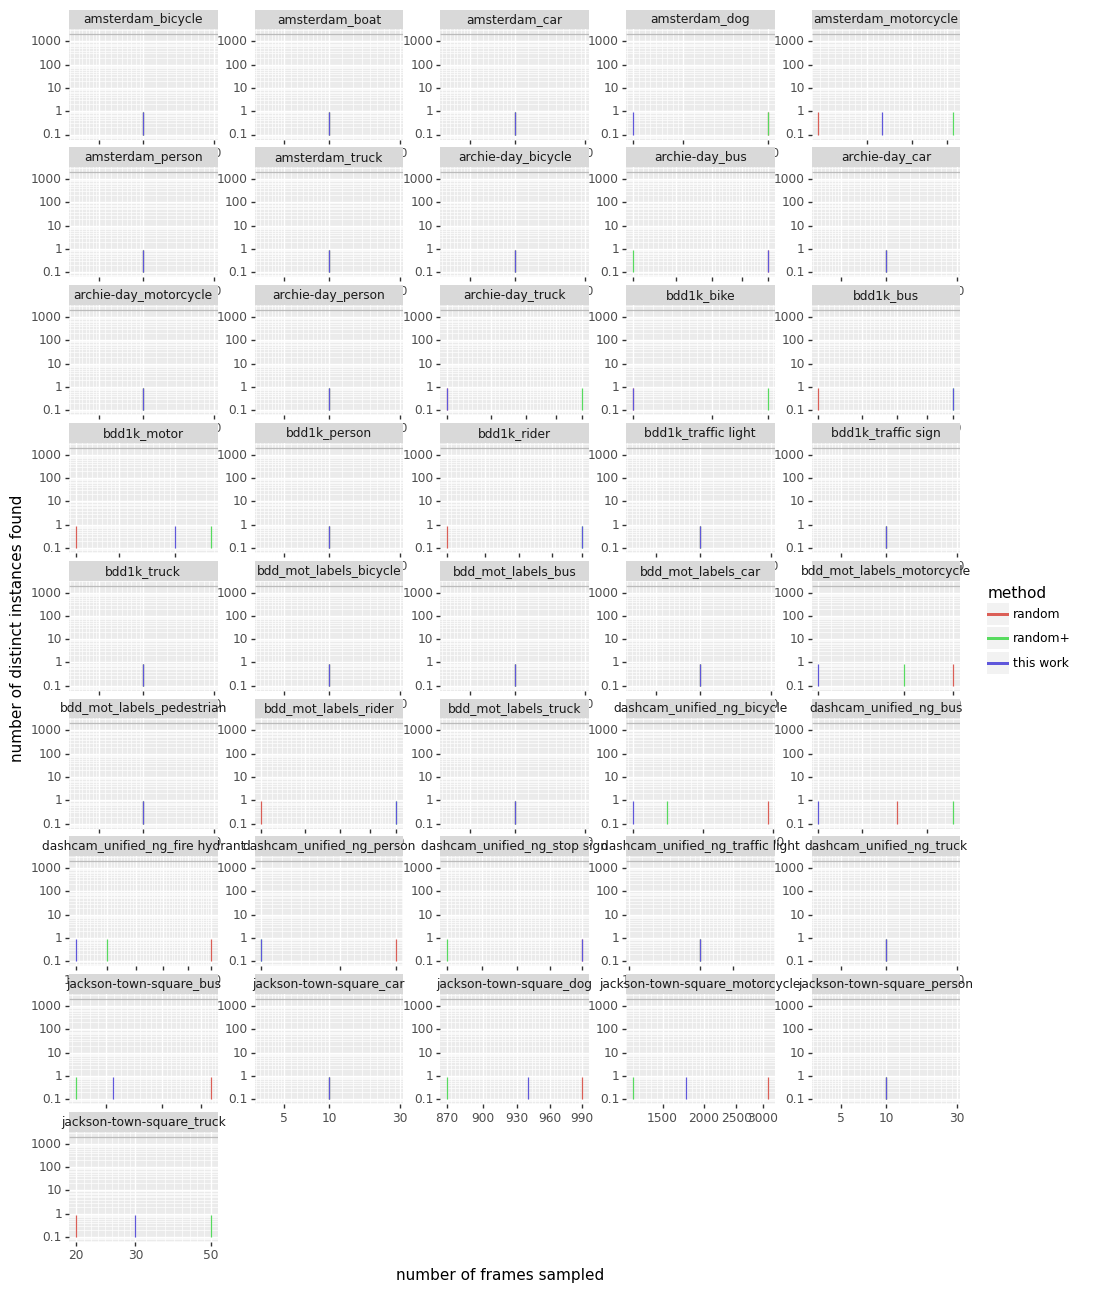

<ggplot: (8748123516481)>

In [35]:
simplot

In [31]:
# pdf.groupby('task').size().reset_index()

,task,0
0,amsterdam_bicycle,27
1,amsterdam_boat,27
2,amsterdam_car,27
3,amsterdam_dog,27
4,amsterdam_motorcycle,27
5,amsterdam_person,27
6,amsterdam_truck,27
7,archie-day_bicycle,27
8,archie-day_bus,27
9,archie-day_car,27


In [ ]:
#pdf